In [1]:
import os
import sys
import h5py
import pandas as pd
import numpy as np
import tqdm
import pickle
import matplotlib
import matplotlib.pyplot as plt
import multiprocessing as mp
import scipy.stats as ss
from datetime import datetime
from keras.models import load_model
from keras.models import Sequential
from keras.layers import *
from keras.models import Model
from keras import backend as K

# Interpreting the Tn5 bias model

In [2]:
# One-hot encoding of a DNA sequence.
# Input: 
# (1) seq: a string of length L consisting of A/C/G/T
# Returns: 
# (1) onehot: L-by-4 encoded matrix
def onehot_encode(seq):
    mapping = pd.Series(index = ["A", "C", "G", "T"], data = [0, 1, 2, 3])
    bases = [base for base in seq]
    base_inds = mapping[bases]
    onehot = np.zeros((len(bases), 4))
    onehot[np.arange(len(bases)), base_inds] = 1
    return onehot

# Generates a random sequence containing A/C/G/T of length n
def random_seq(n):
    bases = ["A", "C", "G", "T"]
    rand_seq = "".join([np.random.choice(bases) for i in range(n)])
    return rand_seq

In [3]:
# Load pre-trained Tn5 bias model
model = load_model("../../data/shared/Tn5_NN_model.h5")

2022-07-09 09:56:05.271445: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/helmod/apps/centos7/Core/cuda/11.1.0-fasrc01/cuda/extras/CUPTI/lib64:/n/helmod/apps/centos7/Core/cuda/11.1.0-fasrc01/cuda/lib64:/n/helmod/apps/centos7/Core/cuda/11.1.0-fasrc01/cuda/lib:/n/helmod/apps/centos7/Core/cudnn/8.1.0.77_cuda11.2-fasrc01/lib64
2022-07-09 09:56:05.272050: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-09 09:56:05.272462: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (holy7c18312.rc.fas.harvard.edu): /proc/driver/nvidia/version does not exist
2022-07-09 09:56:05.274637: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneD

In [4]:
motif = "CGCACAGTCCAGGACTGTGCA"
motif_radius = int((len(motif) - 1) / 2)
context_radius = 50
diff_list = []
for dist in tqdm.tqdm(range(-40, 40)):
    motif_seqs = []
    control_seqs = []
    for i in range(500):
        rand_seq_left = random_seq(context_radius + dist - motif_radius)
        rand_seq_right = random_seq(context_radius - dist - motif_radius)
        motif_seq = rand_seq_left + motif + rand_seq_right
        control_seq = rand_seq_left + random_seq(len(motif)) + rand_seq_right
        motif_seqs.append(motif_seq)
        control_seqs.append(control_seq)

    motif_seqs = np.array([onehot_encode(seq) for seq in motif_seqs])
    control_seqs = np.array([onehot_encode(seq) for seq in control_seqs])

    # Calculate the difference in predicted
    diff = model.predict(motif_seqs) - model.predict(control_seqs)
    diff_list.append([np.percentile(diff, 5), np.mean(diff), np.percentile(diff, 95)])

100%|██████████| 80/80 [01:14<00:00,  1.07it/s]


In [5]:
diff_data = np.array(diff_list)

Text(0, 0.5, 'Average change in predicted bias\n(log transformed)')

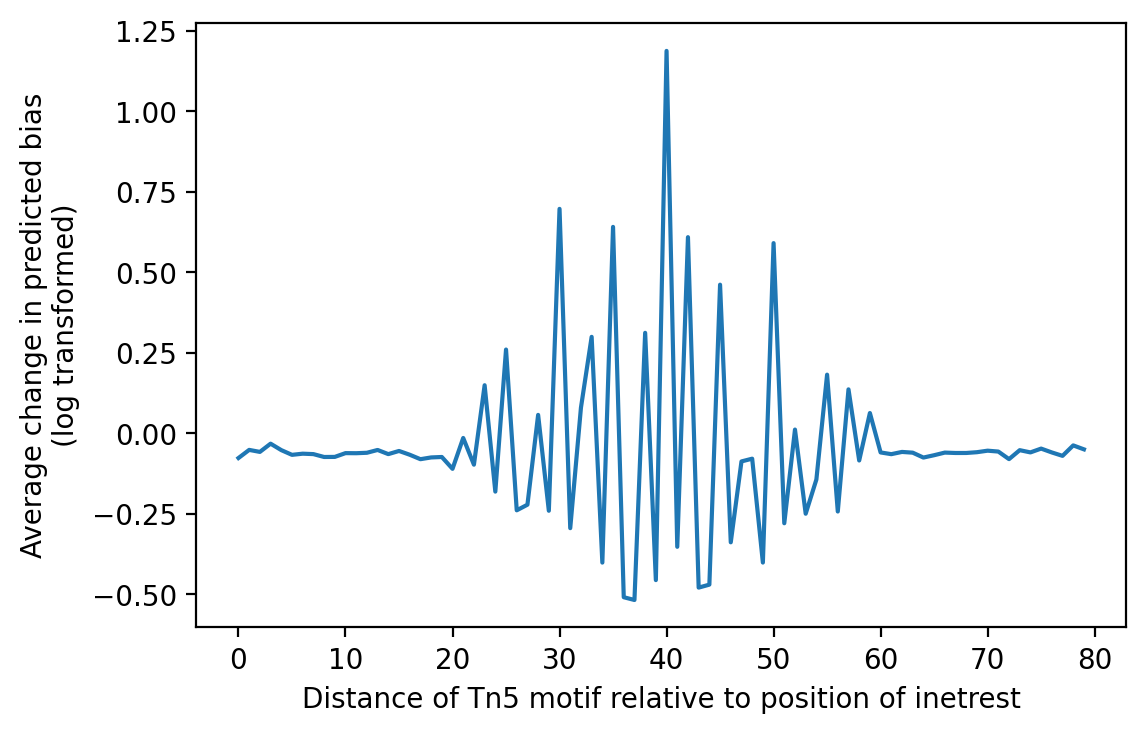

In [6]:
plt.figure(dpi = 200)
plt.plot(diff_data[:,1])
plt.xlabel("Distance of Tn5 motif relative to position of inetrest")
plt.ylabel("Average change in predicted bias\n(log transformed)")

In [7]:
left_half_motif = "CGCACAGTCC"
right_half_motif = "GGACTGTGCA"
motif_radius = int((len(motif) - 1) / 2)
context_radius = 50
pred_bias = []
for gap_radius in tqdm.tqdm(range(20)):
    seqs = []
    for i in range(500):
        rand_seq_left = random_seq(context_radius - gap_radius - motif_radius)
        rand_seq_gap = random_seq(2 * gap_radius + 1)
        rand_seq_right = random_seq(context_radius - gap_radius - motif_radius)
        seq = rand_seq_left + left_half_motif + rand_seq_gap + \
              right_half_motif + rand_seq_right 
        seqs.append(seq)

    seqs = np.array([onehot_encode(seq) for seq in seqs])

    # Calculate the difference in predicted
    pred_bias.append(np.mean(model.predict(seqs)))

100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Text(0, 0.5, 'Average predicted bias\n(log transformed)')

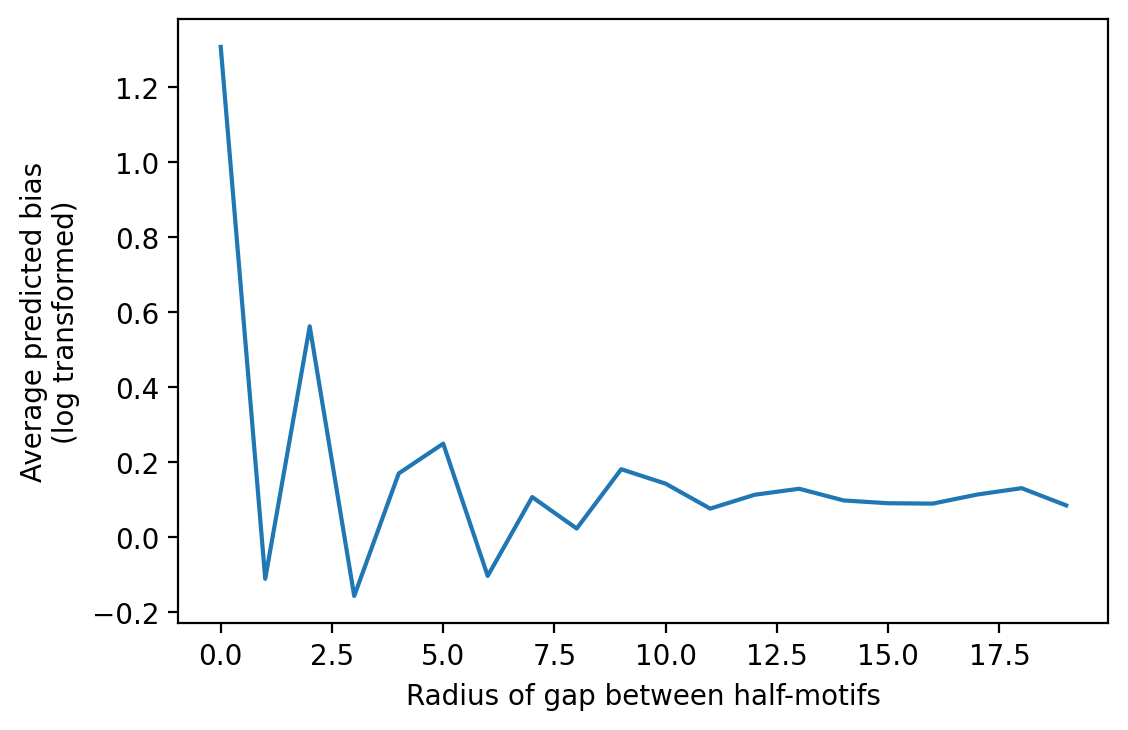

In [8]:
plt.figure(dpi = 200)
plt.plot(pred_bias)
plt.xlabel("Radius of gap between half-motifs")
plt.ylabel("Average predicted bias\n(log transformed)")